In [1]:
import pandas as pd
from IPython.display import display, HTML
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
import datetime

np.random.seed(42)

Using TensorFlow backend.


In [2]:
from math import pi
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, output_file

output_notebook()

Loading BokehJS ...

In [3]:
HOURS_IN_DAY = 24
MINUTES_IN_HOUR = 60
SECONDS_IN_MINUTE = 60
AGGREGATION_PERIOD = 30 #Model uses 30 minutes candles

DAY_WINDOW = int(HOURS_IN_DAY * MINUTES_IN_HOUR / AGGREGATION_PERIOD)

In [4]:
# Force CPU usage
import tensorflow as tf
from keras import backend as K

num_cores = 8

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : 1, 'GPU' : 0})
session = tf.Session(config=config)
K.set_session(session)

In [5]:
# For plot

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax2.plot(history.history['binary_accuracy'], label = "training")
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [6]:
def aggregate_market_values(dataframe, aggregation_period, unix_time=False):
    """
    timestamp / open / high / low / close / volume btc / volume currency / weighted price
    """    
    data = dataframe.copy()
    aggregation_factor = aggregation_period * SECONDS_IN_MINUTE
    
    if not unix_time:
        data.Timestamp = data.Timestamp.astype(np.int64) // 10**9
    
    data = data.groupby(data.Timestamp // aggregation_factor).agg({
        'Open' : 'first',
        'High' : np.max,
        'Low' : np.min,
        'Close' : 'last',
        'Volume_(BTC)' : np.sum ,
        'Volume_(Currency)' : np.sum,
        'Weighted_Price' : np.mean,
    }).reset_index()
    
    data.Timestamp *= aggregation_factor
    
    if not unix_time:
        data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')
    
    return data

def first_in_window(dataframe, aggregation_period, unix_time=False):
    """
    timestamp / open / high / low / close / volume btc / volume currency / weighted price
    """    
    data = dataframe.copy()
    aggregation_factor = aggregation_period * SECONDS_IN_MINUTE
    
    if not unix_time:
        data.Timestamp = data.Timestamp.astype(np.int64) // 10**9
            
    data = data.groupby(data.Timestamp // aggregation_factor).first().reset_index(drop=True)
            
    if not unix_time:
        data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')
    
    return data
    

In [7]:
df_raw_part1 = pd.read_csv('Data/bitstampUSD_1-min_data_2012-01-01_to_2018-01-08.csv')
df_raw_part2 = pd.read_csv('Data/bitstampUSD_30-min_data_january.csv', date_parser=True)

# Aggregate first part of data into chunks of 30 mins, second part already aggregated
df_p1 = aggregate_market_values(df_raw_part1, 30, unix_time=True)
df_p1.Timestamp = pd.to_datetime(df_p1.Timestamp, unit='s')

df_p2 = df_raw_part2
df_p2.Timestamp = pd.to_datetime(df_p2.Timestamp)

df_raw = pd.concat([df_p1, df_p2]).reset_index(drop=True)

display(df_raw[105370:105372])
display(df_raw.tail())
print(df_raw.dtypes)

,Close,High,Low,Open,Timestamp,Volume_(BTC),Volume_(Currency),Weighted_Price
105370,16166.78,16176.96,16102.05,16173.98,2018-01-08 00:00:00,25.633791,4.132784e+05,16122.40664
105371,15956.66,16300.00,15954.16,16293.99,2018-01-08 00:30:00,221.650000,3.577715e+06,16140.98000


,Close,High,Low,Open,Timestamp,Volume_(BTC),Volume_(Currency),Weighted_Price
108615,8453.20,8505.00,8435.94,8503.41,2018-03-16 14:30:00,250.99,2126237.50,8471.47
108616,8511.47,8527.24,8450.10,8452.99,2018-03-16 15:00:00,321.19,2727121.08,8490.73
108617,8554.04,8613.06,8482.47,8510.00,2018-03-16 15:30:00,563.11,4813543.76,8548.16
108618,8541.17,8572.28,8472.24,8554.42,2018-03-16 16:00:00,305.72,2605758.19,8523.24
108619,8541.19,8553.83,8522.02,8547.41,2018-03-16 16:30:00,30.78,262893.41,8539.96


Close                       float64
High                        float64
Low                         float64
Open                        float64
Timestamp            datetime64[ns]
Volume_(BTC)                float64
Volume_(Currency)           float64
Weighted_Price              float64
dtype: object


In [8]:
df_plot = df_raw.copy()

aggregation_factor = 24 * 60 #24h candles

df_plot = aggregate_market_values(df_plot, 12 * 60)

inc = df_plot.Close >= df_plot.Open
dec = df_plot.Open > df_plot.Close
barWidth = 0.66 * aggregation_factor * 60 * 1000 # 30 minutes in ms

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=990, title = "MSFT Candlestick")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

p.segment(df_plot.Timestamp, df_plot.High, df_plot.Timestamp, df_plot.Low, color="black")
p.vbar(df_plot.Timestamp[inc], barWidth, df_plot.Open[inc], df_plot.Close[inc], fill_color="#48D922", line_color="black")
p.vbar(df_plot.Timestamp[dec], barWidth, df_plot.Open[dec], df_plot.Close[dec], fill_color="#FF2828", line_color="black")

show(p)

# Objective 

We aim to predict price changes across intervals of 24 hours. More specifically, at the end of each day, the model should predict the price of Bitcoin in the following 24 hours.

In [30]:
def add_MA_n_days_age(num_days):
    num_days_str = str(num_days)
    
    df[['Open_W_MA_'+num_days_str,'High_W_MA_'+num_days_str,'Low_W_MA_'+num_days_str,'Close_W_MA_'+num_days_str]] = df[['Open_W','High_W','Low_W','Close_W']].rolling(window=DAY_WINDOW * num_days).mean()
    df[['Open_MA_'+num_days_str,'High_MA_'+num_days_str,'Low_MA_'+num_days_str,'Close_MA_'+num_days_str]] = df[['Open','High','Low','Close']].rolling(window=DAY_WINDOW * num_days).mean()
    df[['Open_EMA_'+num_days_str,'High_EMA_'+num_days_str,'Low_EMA_'+num_days_str,'Close_EMA_'+num_days_str]] = df[['Open','High','Low','Close']].ewm(span=DAY_WINDOW * num_days).mean()

    df[['Open_MAX_'+num_days_str,'High_MAX_'+num_days_str,'Low_MAX_'+num_days_str,'Close_MAX_'+num_days_str]] = df[['Open','High','Low','Close']].rolling(window=DAY_WINDOW * num_days).max()
    df[['Open_MIN_'+num_days_str,'High_MIN_'+num_days_str,'Low_MIN_'+num_days_str,'Close_MIN_'+num_days_str]] = df[['Open','High','Low','Close']].rolling(window=DAY_WINDOW * num_days).min()

    df['Open_TENKAN_'+num_days_str] = 0.5 * (df['Open_MIN_'+num_days_str] + df['Open_MAX_'+num_days_str])
    df['High_TENKAN_'+num_days_str] = 0.5 * (df['High_MIN_'+num_days_str] + df['High_MAX_'+num_days_str])
    df['Low_TENKAN_'+num_days_str] = 0.5 * (df['Low_MIN_'+num_days_str] + df['Low_MAX_'+num_days_str])
    df['Close_TENKAN_'+num_days_str] = 0.5 * (df['Close_MIN_'+num_days_str] + df['Close_MAX_'+num_days_str])

def add_prices_n_days_ago(num_days):
    num_days_str = str(num_days)
    df[['Open_S_'+num_days_str,'High_S_'+num_days_str,'Low_S_'+num_days_str,'Close_S_'+num_days_str]] = df[['Open','High','Low','Close']].shift(DAY_WINDOW * num_days)

def create_weak_labels(data):
    """
    Label is 1 if price increases or 0 otherwise
    """
    r = data.copy()
    current_close = r['Close']
    future_close = r['Close'].shift(-DAY_WINDOW)

    r['Weak_Label'] = 1 * (future_close > current_close)
    
    return r
                      
def create_strong_sell_labels(data, threshold):
    """
    Label is 1 if price decrease by more that threshold %, 0 otherwise
    """
    r = data.copy()
    current_close = r['Close']
    future_close = r['Close'].shift(-DAY_WINDOW)
    r['Strong_Sell_Label'] = 1 * (((future_close - current_close) / current_close) < -threshold)
    
    return r

def create_strong_buy_labels(data, threshold):
    """
    Label is 1 if price increase by more that threshold %, 0 otherwise
    """
    r = data.copy()
    current_close = r['Close']
    future_close = r['Close'].shift(-DAY_WINDOW)
    r['Strong_Buy_Label'] = 1 * ((future_close - current_close) / current_close > threshold)
    
    return r
    

In [10]:
t = 0.1

tmp = create_weak_labels(df_raw)
tmp = create_strong_buy_labels(tmp, t)
tmp = create_strong_sell_labels(tmp, t)
display(tmp[0:240: 2 * 24])

print(tmp.describe())

,Close,High,Low,Open,Timestamp,Volume_(BTC),Volume_(Currency),Weighted_Price,Weak_Label,Strong_Buy_Label,Strong_Sell_Label
0,4.39,4.39,4.39,4.39,2011-12-31 07:30:00,3.644647,16.0000,4.39,1,0,0
48,4.58,4.58,4.58,4.58,2012-01-01 07:30:00,45.060000,206.3748,4.58,1,0,0
96,5.00,5.00,5.00,5.00,2012-01-02 07:30:00,303.000000,1515.0000,5.00,0,0,0
144,5.00,5.00,5.00,5.00,2012-01-03 07:30:00,571.440000,2857.2000,5.00,0,0,0
192,4.93,4.93,4.93,4.93,2012-01-04 07:30:00,290.400000,1431.6720,4.93,1,1,0


               Close           High            Low           Open  \
count  108620.000000  108620.000000  108620.000000  108620.000000   
mean     1249.570211    1256.892187    1241.106251    1249.495719   
std      2776.113561    2796.364277    2752.981890    2776.037148   
min         4.140000       4.140000       1.500000       4.140000   
25%       117.397500     117.900000     116.627500     117.400000   
50%       393.355000     394.905000     391.010000     393.385000   
75%       710.092500     712.990000     706.762500     710.395000   
max     19600.010000   19666.000000   19508.480000   19626.300000   

        Volume_(BTC)  Volume_(Currency)  Weighted_Price     Weak_Label  \
count  108620.000000       1.086200e+05   108620.000000  108620.000000   
mean      335.024034       3.975405e+05     1249.414593       0.551989   
std       597.351920       1.333389e+06     2775.656316       0.497292   
min         0.027968       2.999990e-01        4.140000       0.000000   
25%     

## Simple model

To assess the performance of our model, we devise a simple naïve model as a benchmark. Our simple model looks at the price change in the last 24H and assume that this change will repeat in the next 24H. More specifically, let $P_p, P_c, P_f$ be respectively the previous, current and future price of Bitcoin (in intervals of 24 hours). We have:

$$ P_f = P_c + (P_c - P_p) $$

In [11]:
def naive_predictor(previous, current):
    return current.Close + ((current.Close - previous.Close) / previous.Close) * current.Close

def naive_predict(data):  
    P_c = data.Close
    P_p = data.Close.shift(DAY_WINDOW)
    
    df = pd.DataFrame(1 * (P_p < P_c))
    df.columns = ['Naive_Predict']
    
    return df
    

## Simple model performance

In [12]:
def mean_square_loss(predicted_labels, true_labels):
    assert len(predicted_labels) == len(true_labels)
    return np.mean((predicted_labels - true_labels)**2)

def accuracy(predicted_labels, true_labels):
    return np.mean(predicted_labels == true_labels)

In [13]:
labelled_data = create_weak_labels(df_raw)
predicted_labels = naive_predict(df_raw)

join = pd.concat([labelled_data, predicted_labels], axis=1)[::2*24].dropna()

display(join.head())

print(accuracy(join.Weak_Label, join.Naive_Predict))

,Close,High,Low,Open,Timestamp,Volume_(BTC),Volume_(Currency),Weighted_Price,Weak_Label,Naive_Predict
0,4.39,4.39,4.39,4.39,2011-12-31 07:30:00,3.644647,16.0000,4.39,1,0
48,4.58,4.58,4.58,4.58,2012-01-01 07:30:00,45.060000,206.3748,4.58,1,1
96,5.00,5.00,5.00,5.00,2012-01-02 07:30:00,303.000000,1515.0000,5.00,0,1
144,5.00,5.00,5.00,5.00,2012-01-03 07:30:00,571.440000,2857.2000,5.00,0,0
192,4.93,4.93,4.93,4.93,2012-01-04 07:30:00,290.400000,1431.6720,4.93,1,0


0.483870967742


In [14]:
last_n_points = -5000

points = df_raw.iloc[join.index]

buy_points = points[join.Naive_Predict == 1]
sell_points = points[1 == 1 + (-1 * join.Naive_Predict)]

p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=990, title = "MSFT Candlestick")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

p.line(points.Timestamp[last_n_points * 2 :], np.log(points.Close[last_n_points * 2:]), line_color='black', line_width=2, line_alpha=0.6)
p.scatter(buy_points.Timestamp[last_n_points:], np.log(buy_points.Close[last_n_points:]), size=8, color='blue')
p.scatter(sell_points.Timestamp[last_n_points:], np.log(sell_points.Close[last_n_points:]), size=8, color='red')
p.line(df_raw.Timestamp[last_n_points * 2 * 2 * 24:], np.log(df_raw.Close[last_n_points * 2 * 2 * 24:]), line_color='black', line_alpha=0.3)

show(p)

## Neural network



In [56]:
def split_dataset(data, fraction):
    l = len(data)
    
    train = data[0 : int(l * fraction)]
    test = data[ int(l*fraction) :]
    
    return train, test

### Small change oracle

In [127]:
window_aggregation = 30

labelled_data = create_weak_labels(df_raw)

display(labelled_data)

df = labelled_data.copy()
df = df.drop('Timestamp',1)
df = df.drop('Weighted_Price',1)

#df[['Open','High','Low','Close']] = df[['Open','High','Low','Close']].apply(lambda x: np.log(x))

display(df)


,Close,High,Low,Open,Timestamp,Volume_(BTC),Volume_(Currency),Weighted_Price,Weak_Label
0,4.39,4.39,4.39,4.39,2011-12-31 07:30:00,3.644647,1.600000e+01,4.390000,1
1,4.39,4.39,4.39,4.39,2011-12-31 08:00:00,13.667426,6.000000e+01,4.390000,1
2,4.39,4.39,4.39,4.39,2011-12-31 08:30:00,13.667426,6.000000e+01,4.390000,1
3,4.39,4.39,4.39,4.39,2011-12-31 09:00:00,13.667426,6.000000e+01,4.390000,1
4,4.39,4.39,4.39,4.39,2011-12-31 09:30:00,13.667426,6.000000e+01,4.390000,1
5,4.39,4.39,4.39,4.39,2011-12-31 10:00:00,13.667426,6.000000e+01,4.390000,1
6,4.39,4.39,4.39,4.39,2011-12-31 10:30:00,13.667426,6.000000e+01,4.390000,1
7,4.39,4.39,4.39,4.39,2011-12-31 11:00:00,13.667426,6.000000e+01,4.390000,1
8,4.39,4.39,4.39,4.39,2011-12-31 11:30:00,13.667426,6.000000e+01,4.390000,1
9,4.39,4.39,4.39,4.39,2011-12-31 12:00:00,13.667426,6.000000e+01,4.390000,1


,Close,High,Low,Open,Volume_(BTC),Volume_(Currency),Weak_Label
0,4.39,4.39,4.39,4.39,3.644647,1.600000e+01,1
1,4.39,4.39,4.39,4.39,13.667426,6.000000e+01,1
2,4.39,4.39,4.39,4.39,13.667426,6.000000e+01,1
3,4.39,4.39,4.39,4.39,13.667426,6.000000e+01,1
4,4.39,4.39,4.39,4.39,13.667426,6.000000e+01,1
5,4.39,4.39,4.39,4.39,13.667426,6.000000e+01,1
6,4.39,4.39,4.39,4.39,13.667426,6.000000e+01,1
7,4.39,4.39,4.39,4.39,13.667426,6.000000e+01,1
8,4.39,4.39,4.39,4.39,13.667426,6.000000e+01,1
9,4.39,4.39,4.39,4.39,13.667426,6.000000e+01,1


In [128]:
df.shape

(108620, 7)

In [129]:
df.describe()

,Close,High,Low,Open,Volume_(BTC),Volume_(Currency),Weak_Label
count,108620.000000,108620.000000,108620.000000,108620.000000,108620.000000,1.086200e+05,108620.000000
mean,1249.570211,1256.892187,1241.106251,1249.495719,335.024034,3.975405e+05,0.551989
std,2776.113561,2796.364277,2752.981890,2776.037148,597.351920,1.333389e+06,0.497292
min,4.140000,4.140000,1.500000,4.140000,0.027968,2.999990e-01,0.000000
25%,117.397500,117.900000,116.627500,117.400000,79.443621,1.256135e+04,0.000000
50%,393.355000,394.905000,391.010000,393.385000,173.214145,4.975225e+04,1.000000
75%,710.092500,712.990000,706.762500,710.395000,366.229904,1.818109e+05,1.000000
max,19600.010000,19666.000000,19508.480000,19626.300000,47399.607407,5.059766e+07,1.000000


In [130]:
df[['Open_W','High_W','Low_W','Close_W']] = df[['Open','High','Low','Close']].divide(df['Volume_(BTC)'],axis = 0)

#df[['Open','High','Low','Close']] = df[['Open','High','Low','Close']].apply(lambda x: np.log(x))

add_prices_n_days_ago(1)
add_prices_n_days_ago(2)
add_prices_n_days_ago(3)

add_MA_n_days_age(5)
add_MA_n_days_age(10)
add_MA_n_days_age(15)

plusieurs y gains selon différents temps + vote

In [131]:
display(df.sample(5))

,Close,High,Low,Open,Volume_(BTC),Volume_(Currency),Weak_Label,Open_W,High_W,Low_W,...,Low_MAX_15,Close_MAX_15,Open_MIN_15,High_MIN_15,Low_MIN_15,Close_MIN_15,Open_TENKAN_15,High_TENKAN_15,Low_TENKAN_15,Close_TENKAN_15
40551,491.23,491.54,488.71,491.54,18.595619,9124.390336,0,26.433107,26.433107,26.280921,...,538.30,544.91,349.20,357.99,339.79,350.13,447.055,452.995,439.045,447.52
38127,689.00,698.99,685.88,695.25,678.425720,469634.249053,0,1.024799,1.030312,1.010988,...,692.00,710.00,409.98,445.00,400.00,410.00,559.985,577.500,546.000,560.00
41845,496.72,497.37,493.53,494.48,108.121250,53648.798929,0,4.573384,4.600113,4.564598,...,496.00,498.80,422.00,424.89,420.27,422.64,460.400,462.445,458.135,460.72
68223,331.47,332.04,331.47,331.91,77.280320,25635.027144,1,4.294884,4.296566,4.289190,...,338.18,342.89,300.75,305.86,294.00,301.37,321.820,330.980,316.090,322.13
6252,5.04,5.06,5.04,5.06,487.669587,2466.594744,0,0.010376,0.010376,0.010335,...,5.15,5.15,4.86,4.86,4.81,4.81,5.005,5.005,4.980,4.98


In [132]:
df = df.dropna(how ='any')

labels = df.Weak_Label
df = (df-df.mean())/df.std()
df.Weak_Label = labels

df_index = df.index.copy()
df = df.reset_index()
df = df.drop('index',1)


display(df)

,Close,High,Low,Open,Volume_(BTC),Volume_(Currency),Weak_Label,Open_W,High_W,Low_W,...,Low_MAX_15,Close_MAX_15,Open_MIN_15,High_MIN_15,Low_MIN_15,Close_MIN_15,Open_TENKAN_15,High_TENKAN_15,Low_TENKAN_15,Close_TENKAN_15
0,-0.449636,-0.449008,-0.450329,-0.449622,-0.550685,-0.299188,1,-0.354082,-0.354398,-0.353687,...,-0.433007,-0.433029,-0.469101,-0.468375,-0.470985,-0.469267,-0.448154,-0.448108,-0.448876,-0.448277
1,-0.449636,-0.449008,-0.450329,-0.449622,-0.550685,-0.299188,1,-0.354082,-0.354398,-0.353687,...,-0.433007,-0.433029,-0.469101,-0.468375,-0.470985,-0.469267,-0.448154,-0.448108,-0.448876,-0.448277
2,-0.449636,-0.449008,-0.450329,-0.449622,-0.550685,-0.299188,1,-0.354082,-0.354398,-0.353687,...,-0.433007,-0.433029,-0.469101,-0.468375,-0.470985,-0.469267,-0.448154,-0.448108,-0.448876,-0.448277
3,-0.449636,-0.449008,-0.450329,-0.449622,-0.550685,-0.299188,1,-0.354082,-0.354398,-0.353687,...,-0.433007,-0.433029,-0.469101,-0.468375,-0.470985,-0.469267,-0.448154,-0.448108,-0.448876,-0.448277
4,-0.449636,-0.449008,-0.450329,-0.449622,-0.550685,-0.299188,1,-0.354082,-0.354398,-0.353687,...,-0.433007,-0.433029,-0.469101,-0.468375,-0.470985,-0.469267,-0.448154,-0.448108,-0.448876,-0.448277
5,-0.449636,-0.449008,-0.450329,-0.449622,-0.550685,-0.299188,1,-0.354082,-0.354398,-0.353687,...,-0.433007,-0.433029,-0.469101,-0.468375,-0.470985,-0.469267,-0.448154,-0.448108,-0.448876,-0.448277
6,-0.449331,-0.448705,-0.450329,-0.449622,-0.507169,-0.299048,0,-0.385602,-0.384790,-0.385306,...,-0.433007,-0.433029,-0.469101,-0.468375,-0.470985,-0.469267,-0.448154,-0.448108,-0.448876,-0.448277
7,-0.449331,-0.448705,-0.450021,-0.449316,-0.511173,-0.299058,0,-0.383862,-0.384094,-0.383561,...,-0.433007,-0.433029,-0.469101,-0.468375,-0.470985,-0.469267,-0.448154,-0.448108,-0.448876,-0.448277
8,-0.449331,-0.448705,-0.450021,-0.449316,-0.511173,-0.299058,0,-0.383862,-0.384094,-0.383561,...,-0.433007,-0.433029,-0.469101,-0.468375,-0.470985,-0.469267,-0.448154,-0.448108,-0.448876,-0.448277
9,-0.449331,-0.448705,-0.450021,-0.449316,-0.511173,-0.299058,0,-0.383862,-0.384094,-0.383561,...,-0.433007,-0.433029,-0.469101,-0.468375,-0.470985,-0.469267,-0.448154,-0.448108,-0.448876,-0.448277


In [133]:
train, test = split_dataset(df, 0.8)

print(train.shape)
print(test.shape)

train_x = train.drop('Weak_Label',1)
train_y = train['Weak_Label']
test_x = test.drop('Weak_Label',1)
test_y = test['Weak_Label']

display(train_x.head(1))
display(test_x.head(1))

display(train_y.head(1))
display(test_y.head(1))


(86320, 95)
(21581, 95)


,Close,High,Low,Open,Volume_(BTC),Volume_(Currency),Open_W,High_W,Low_W,Close_W,...,Low_MAX_15,Close_MAX_15,Open_MIN_15,High_MIN_15,Low_MIN_15,Close_MIN_15,Open_TENKAN_15,High_TENKAN_15,Low_TENKAN_15,Close_TENKAN_15
0,-0.449636,-0.449008,-0.450329,-0.449622,-0.550685,-0.299188,-0.354082,-0.354398,-0.353687,-0.354053,...,-0.433007,-0.433029,-0.469101,-0.468375,-0.470985,-0.469267,-0.448154,-0.448108,-0.448876,-0.448277


,Close,High,Low,Open,Volume_(BTC),Volume_(Currency),Open_W,High_W,Low_W,Close_W,...,Low_MAX_15,Close_MAX_15,Open_MIN_15,High_MIN_15,Low_MIN_15,Close_MIN_15,Open_TENKAN_15,High_TENKAN_15,Low_TENKAN_15,Close_TENKAN_15
86320,-0.150641,-0.15184,-0.1494,-0.150798,-0.38704,-0.233862,-0.074455,-0.07502,-0.073606,-0.074309,...,-0.181164,-0.181499,-0.116381,-0.120544,-0.1095,-0.116486,-0.156514,-0.158354,-0.153949,-0.156534


0    1
Name: Weak_Label, dtype: int32

86320    1
Name: Weak_Label, dtype: int32

In [134]:
model = Sequential()
model.add(Dense(128, input_dim=94, activation='selu'))
#model.add(Dropout(0.5))
model.add(Dense(128, activation='selu'))
model.add(Dense(128, activation='selu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

history = model.fit(train_x, train_y, epochs = 10, verbose=1)
scores = model.evaluate(test_x, test_y, verbose=0)

model.save('my_model2.h5')

Epoch 1/10
86320/86320 [==============================] - 8s 91us/step - loss: 0.6941 - binary_accuracy: 0.5329
Epoch 2/10
86320/86320 [==============================] - 7s 76us/step - loss: 0.6885 - binary_accuracy: 0.5452
Epoch 3/10
86320/86320 [==============================] - 7s 80us/step - loss: 0.6870 - binary_accuracy: 0.5494
Epoch 4/10
86320/86320 [==============================] - 7s 80us/step - loss: 0.6859 - binary_accuracy: 0.5533
Epoch 5/10
86320/86320 [==============================] - 7s 79us/step - loss: 0.6852 - binary_accuracy: 0.5548
Epoch 6/10
86320/86320 [==============================] - 7s 83us/step - loss: 0.6835 - binary_accuracy: 0.5592
Epoch 7/10
86320/86320 [==============================] - 8s 93us/step - loss: 0.6817 - binary_accuracy: 0.5617
Epoch 8/10
86320/86320 [==============================] - 7s 83us/step - loss: 0.6804 - binary_accuracy: 0.5638
Epoch 9/10
86320/86320 [==============================] - 7s 80us/step - loss: 0.6795 - binary_accuracy:

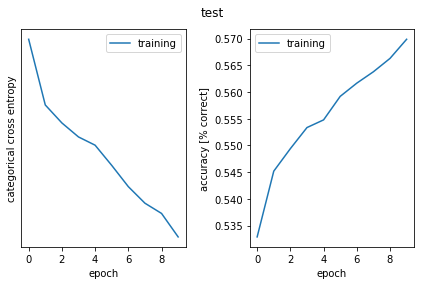

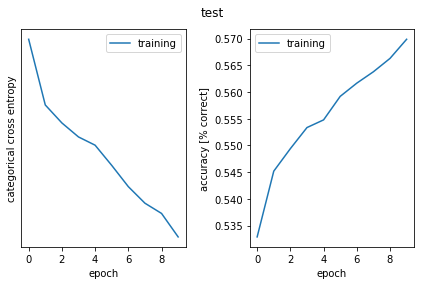

In [135]:
plot_history(history,"test")

In [136]:
print(scores)


[1.3798515425830917, 0.48653908530651963]


In [ ]:
prediction = model.predict(test_x2)


last_n_points = -len(prediction)

p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=990, title = "MSFT Candlestick")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

p.line(range(len(prediction)), np.squeeze(prediction), line_color='blue')
p.line(range(len(prediction)), np.log(df_raw.Close[last_n_points:]), line_color='red')

show(p)

In [ ]:
correct = []
not_correct = []

prediction = model.predict(test_x2)

for i in range(len(prediction)):
    if prediction[i].round() == test_y2.values[i]:
        correct.append([i,test_x2['Open'].values[i]])
    else:
        not_correct.append([i,test_x2['Open'].values[i]])

fig, ax = plt.subplots(figsize=(10, 10),dpi = 80)
a,b = zip(*correct)
ax.plot(a,b, '.r',markersize=0.2)
a,b = zip(*not_correct)
ax.plot(a,b, '.b',markersize=0.2)

plt.show()

## Investing using the model
We use the model to apply the following simple investment strategy. At the end of each day, we take either a long or short position for $100. No matter what happens, the position is liquidated after 24H. Of course, the choice of the position is dependent on the price increase or decrease of the model

In [ ]:
daily_amount = 100 #dollars

def compute_investment_return(prices, decisions):
    prices_in_24h = prices.shift(-DAY_WINDOW)
    return np.sum( ((prices_in_24h - prices)/prices) * daily_amount * decisions)

### The anarchist
The anarchist decide whether to invest or not based on a (bit)coin flip:

In [ ]:
sum = 0
prices = df_raw.iloc[test2.index].Close
l = len(prices)
for i in range(10000):
    choices = 2 * np.random.choice(2, l) - 1
    sum += compute_investment_return(prices, choices)

print(sum / 10000.0)

### Simple model

In [ ]:
#true_labels = pd.DataFrame(create_labels(df_24h).Label)
predicted_labels = naive_predict( df_raw.iloc[test2.index].copy())
predicted_labels.columns = ['Timestamp', 'Price_Prediction']

prices = df_raw.iloc[test2.index].Close

join = pd.concat([predicted_labels, prices], axis=1).dropna()
join = first_in_window(join.copy(), 24*60)
join['Decision'] = 2 * (join.Price_Prediction >= join.Close) - 1 # Long: 1 Short: -1
display(join)

decisions_simple = join.copy().Decision

print(len(join))

print(compute_investment_return(join.Close, join.Decision))

### Neural net

In [ ]:
prediction = pd.DataFrame(np.exp(model.predict(test_x2)).squeeze())
prediction.columns = ['Price_Prediction']
prediction['previous'] = prediction.shift(DAY_WINDOW)

prices = df_raw.iloc[test2.index][['Timestamp', 'Close']].reset_index(drop=True)

join = pd.concat([prediction, prices], axis=1).dropna()
join = first_in_window(join.copy(), 24*60)
join['Decision'] = 2 * (join.Price_Prediction >= join.previous) - 1 # Long: 1 Short: -1
display(join)

decisions_nn = join.copy().Decision

print(len(join))

print(compute_investment_return(join.Close, join.Decision))

In [ ]:
print(np.sum(decisions_simple.values == decisions_nn[1:].values))

In [ ]:
from keras.models import load_model
 
    

with tf.device('/cpu:0'):

    model = load_model('my_model.h5')
    scores = model.evaluate(test_x, test_y, verbose=0)
    print(scores)
    
    del model
